## Application 3: The Empirical Interpolation Method

Contributed by: Kyle Beyer, Pablo Giuliani

In this section we explain the application of the Empirical Inteprolation Method (known as EIM in the Reduced Basis Method literature) to emulate problems with more interesting (non-affine) dependence on their parameters. For further reading on this topic see chapter V of [this book](https://link.springer.com/book/10.1007/978-3-319-22470-1).

Continuing from the previous section, we have the same Hamiltonian as the radial part of the scattering equation:

\begin{equation}
    F_\alpha(\phi)=\left(-\frac{d^2}{dr^2}+\frac{\ell(\ell+1)}{r^2}+U(r,\alpha)-p^2\right)\phi(r)=0,
\end{equation}

Let's now consider the following potential with Woods-Saxon form:

\begin{equation}
    U(r;R,a) = -2\mu V_0\frac{1}{1 + \exp{\frac{r-R}{a}}}.
\end{equation}

We would like our Reduced Basis to correlty approximate our solution when we vary $R$, $a$, and/or the momentum $p$. First, let's apply the scaling to eliminate the $p$ dependence on the equation and have it only in the effective potential:

\begin{equation}
  \tilde U(s;p,S,z) = -\frac{ 2 \mu V_0 }{ p^2}  \frac{1}{ 1 + \exp{ \frac{s-S}{ z }}},
\end{equation}

where we've defined $S = R p$ and $z = a p$.

Notice how our parameters of interest are distincively non-affine, we can't separate the potential as a product of only a function of $s$ and a function of only $\{V_0,S,z,p\}$. A Reduced Basis informed on a set high fidelity solutions for varios sets of parameters $\alpha_i=\{V_{0,i},S_i,z_i,p_i\}$ could still in principle be a good approximation for a new target parameter $\alpha_t$. The problem is that the Galerkin projection equations we used in the previous sections would have to be re-constructed every time, involving opperations in the high fidelity space (integrals in the variable $s$). 

The clever idea behind the Empirical Interpolation Method is to find an approximation of $\tilde U$, which we will call $\tilde U_\text{EIM}$, that is indeed affine in the parameters: 


\begin{equation}
\tilde U(s; \alpha)  \approx \tilde{U}_\text{EIM} (s; \alpha)  = \sum_k^M \beta_k(\alpha) U_k(s),
\end{equation}

where the coefficients $\beta_k$ depend on $\alpha$ and need to be determined somehow, while the functions $U_k(s)$ are informed on exact forms of the potential for several values of the parameters $\alpha$. To explain the method, we will only focus on changing the potential radius $R$ ($S$ in the re-scaled notation), $z$ and $p$ will be fixed, so we will ommit them going forward.

We can see an analogy with what we did before in the space of wavefunctions, but now in the space of operators $\tilde U(s;S)$: we will evaluate $N$ snapshots of $U(s;S)$, with $S$ evaluated at each value on the training space $T\equiv \{S_i\}$ for $i=1,...N$, which we are free to choose. As before, we will then do a Principal Component Analysis to find $M < N$ dimensions that suitably encapsulate the information content of $U(s;S)$ as we vary $S \in T$. 

In the previous section, the associated coefficients $a_k$ for the reduced basis approximation of the wave function were obtained by the Galerkin projection on the residual of the differential equation $F(\hat \phi)$. This is done because we don't have access to the exact solution $\phi$ for a given parameter target $\alpha$, so we use the information content of the residual to inform our reduced basis approximation. In this section, however, we can compute the exact operator $U(s;S)$ at any value of $s$ without incurring into a big computational cost. Therefore, the $M$ coefficients $\beta(S)$ are obtained by enforcing that the approximation $\tilde{U}_\text{EIM} (s; S)$ must be exactly equal to the original potential $\tilde{U}(s;S)$ at some selected locations $s_j$ for $j=1,...,M$ for any value of the parameter $S$:

\begin{equation}
U(s_j; S) - \sum_k^M \beta_k(S) U_k(s_j)=0, \ \text{for } j=1, ... , M
\end{equation}

These equations represent an interpolation scheme, since our approximation $\tilde{U}_\text{EIM} (s; S)$ is expected to interpolate the true potential between the fixed locations $s_j$. Here is the reason for the name of the method: empirical interpolation.


Lets take a look on how to implement this in the code. First, define our constantns and potentials:

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib


pgf = False
if pgf:
    matplotlib.use("pgf")


matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,      
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large'
})

def handle_plot(name=None):
    plt.tight_layout()
    if pgf:
        plt.savefig("{}.pgf".format(name))
    else:
        plt.show()
    plt.close()

hbarc = 197 # MeV • fm
mass = 939 # MeV
energy = 50 # center-of-mass scattering energy, fixed for the first example
k = np.sqrt(mass*energy)/hbarc

In [84]:
def woods_saxon(r, args):
    V0, R, a = args
    return -V0/(1. + np.exp((r-R)/a))
    
def woods_saxon_tilde(s, args):
    return 1./energy * woods_saxon(s/k, args)

# interaction parameters we will use for testing
V0 = 200 # MeV
a  = 0.5 # fm

In [85]:
# create N points, distributed evenly, on our desired range
# it is inexpensive to simply evaluate a potential, so might as well 
# use a large number of training points
N = 200

# let's take a big range (usually, we will know the size of our nucleus to a better accuracy than this, but it serves
#to illustrate the power of the method)
R_min = 3
R_max = 6
T = np.arange(R_min, R_max, (R_max - R_min)/N) 
#T = generate_rand_log(np.log(R_min), np.log(R_max), N=N)

In [86]:
def Utrain(s):
    """
    Takes in an array of s values, spits out a matrix of the Woods-Saxon reduced potential
    evaluated at those s and each S value on T
    """
    tmp = np.zeros(np.outer(s,T).shape)
    TT = tmp + T 
    SS = tmp.T + s
    return np.array([ woods_saxon_tilde(SS.T, (V0, TT, a)) ])[0].T

In [87]:
s_endpts = k * np.array([1e-6, 20]) # dimensionless
s = np.linspace(*s_endpts, 2000)
r = s/k

Umat = Utrain(s)

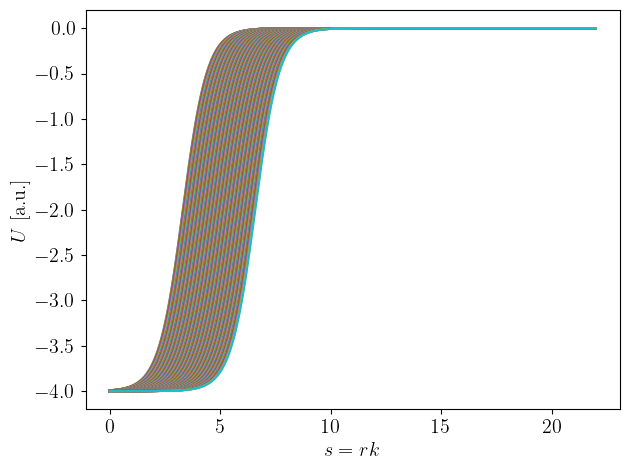

In [88]:
for i in range(N):
    plt.plot(s, Umat[i,:])
plt.xlabel(r"$s = r k$")
plt.ylabel(r"$U$ [a.u.]")

handle_plot("training_eim")
plt.close()

Great, we have a healthy training set of potentials. We would expect that the diffraction minima in differential elastic scattering cross sections, for example, to be quite sensitive to the $R$ value of a Woods-Saxon potential. In other words, all those potentials would produce very different cross-sections! Now let's do PCA and keep just the few that encapsulate most of this information.


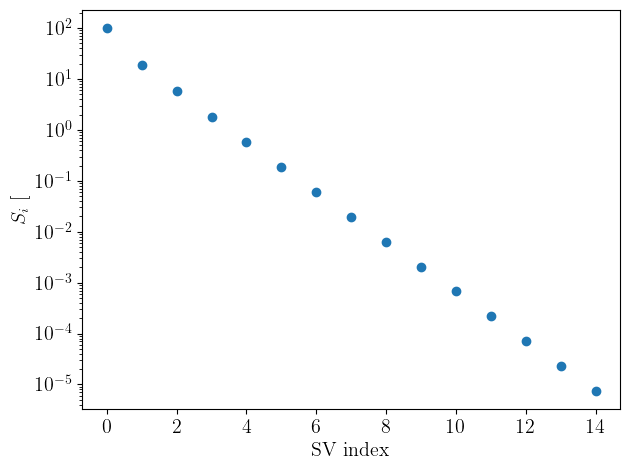

In [89]:
# how big is our final basis?
U, S, Vt = np.linalg.svd(Umat.T, full_matrices=False)
plt.semilogy(100*S[:15]/S[0], "o", linestyle="None")
plt.xlabel("SV index")
plt.ylabel(r"$S_i$ [%]")

handle_plot("svd_eim")
plt.close()

These singular values are dropping nicely; let's take only the first few. 

In [90]:
sv_colors = plt.cm.plasma( S/np.sum(S) ) 

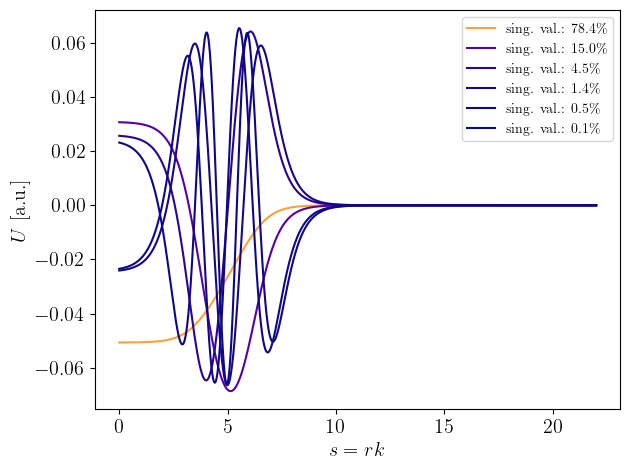

In [91]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

M = 6 # definitely less than N, and way less than the grid size for s!
for i in range(M):
    ax.plot(s, U[:,i], label="sing. val.: {:1.1f}\%".format(100*S[i]/np.sum(S)), color=sv_colors[i])
ax.set_xlabel(r"$s = r k$")
ax.set_ylabel(r"$U$ [a.u.]")
ax.legend()

handle_plot("rb_eim")
plt.close()

U = U[:,:M]

Great, we have our basis $U_k(s)$. We only need $M$ elements to represent most of the information encapsulated in our training set! Now we would like to determine our $M$ coefficients, $\beta_k(S)$. If we evaluate the interpolation equation at $M$ values of $s$, we have $M$ equations, which pairs quite nicely with our $M$ unknown coefficients. But what values of $s$ should we choose? 

Intuitively, we should choose the $s$ values which provide the most information - the places where the variance in potential values between the different parameters is highest. Let's take a look at the standard deviation of our training set as a function of $s$:

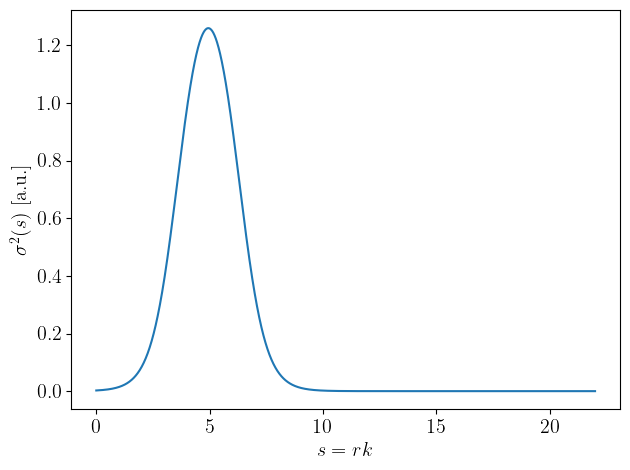

In [92]:
plt.plot(s, np.sqrt(np.var(Umat, axis=0)) )
plt.xlabel(r"$s = r k$")
plt.ylabel(r"$\sigma^2(s)$ [a.u.]")

handle_plot("var_eim")
plt.close()

As a first pass, let's consider two simple ways of choosing our $M$ points, $s_k$.

1. Sampling from the variance distribution
3. uniformly and linearly sampling the range [0,10]

Explore these methods below, or alternatively, hand-pick your own training points to study the sensitivity of the EIM to your choice. Notice the downside of method 1.: for small $M$, the accuracy of the solution can be very sensitive to random noise, but it produces a good solution on average. What if, instead of independently sampling all $M$ points according to the variance, we were to sample each point sequentially, to optimize the variance conditional on the locations of the previous points? This is the essence of the greedy algorithm, which will not cover in this section.

In [93]:
ps = np.sqrt(np.var(Umat, axis=0))

# normalize
ps /= np.trapz(ps, x=s)
ps /= np.sum(ps)

# change this to try method 1 or 2 defined above
sample_from_variance = False

if sample_from_variance:
    sample_pts = np.random.choice(s, size=M, p=ps)
else:
    sample_pts = np.linspace(0.1,10,M)
    

In [94]:
sample_pts


array([ 0.1 ,  2.08,  4.06,  6.04,  8.02, 10.  ])

Once we have chosen the sample points one way or another, we can simultaneously solve our interpolation equation at those points. We know want to solve an equation of the form

\begin{equation}
\mathbf{A} \overline{x}(S) = \overline{b}(S),
\end{equation}

where 

\begin{equation}
{b}_{j} = U(s_j,S),
\end{equation}
and 
\begin{equation}
{A}_{jk} = U_j(s_k),
\end{equation}

and our unkown coefficient functions,
\begin{equation}
{x}_{k} = \beta_k(S).
\end{equation}

In [95]:
A = np.zeros((M,M))
for j in range(M):
    A[:,j] = np.interp( sample_pts, s, U[:,j])

Let's take a look at our potential evaluated at our $M$ chosen sample points, over the range of $S$ values in $T$.

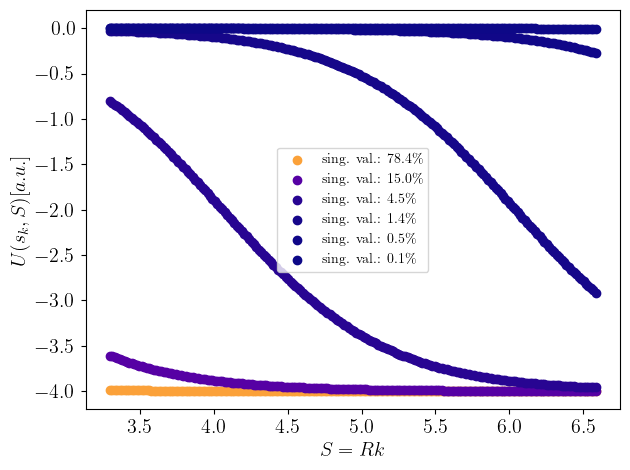

In [96]:
b = np.zeros((M,N))
for ki in range(M):
    b[ki,:] = woods_saxon_tilde(sample_pts[ki], (V0, T, a))
    plt.scatter(k*T, woods_saxon_tilde(sample_pts[ki], (V0, T, a)), 
                label="sing. val.: {:1.1f}\%".format(100*S[ki]/np.sum(S)), color=sv_colors[ki])
plt.xlabel(r"$S = R k$")
plt.ylabel(r"$U(s_k,S) [a.u.]$")
plt.legend()
handle_plot("ws_S_eim")
plt.close()

In [97]:
# solve the system to find the coefficient functions
x = np.einsum('jk,k...', np.linalg.inv(A), b)

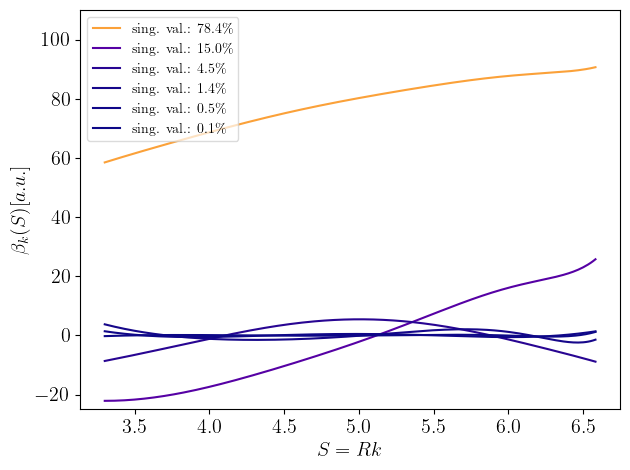

In [98]:
for j in range(M):
    plt.plot(k*T, x[:,j], label="sing. val.: {:1.1f}\%".format(100*S[j]/np.sum(S)), color=sv_colors[j])
plt.xlabel(r"$S = Rk$")
plt.ylabel(r"$\beta_k(S) [a.u.]$ ")
plt.legend(loc='upper left',  fancybox=True, framealpha=0.7)
plt.ylim([-25,110])
handle_plot("betas_eim")
plt.close()

Intuitively, we see that the coefficients generally decrease in magnitude with the singular value, which is a good sanity check. Now let's put it all together to test our affine decomposition of the potential.

In [99]:
def beta(S):
    betas = np.zeros(M)
    for i in range(M):
        betas[i] = np.interp(S, k*T, x[:,i])
    return betas

def ws_affine_decomp(s, args, T):
    '''
    affine decomposition of our Woods-Saxon potential
    '''
    V0, R, a = args
    S = R*k
    
    betas = beta(S)
    Uad   = np.sum(betas * U, axis=1)
        
    return Uad

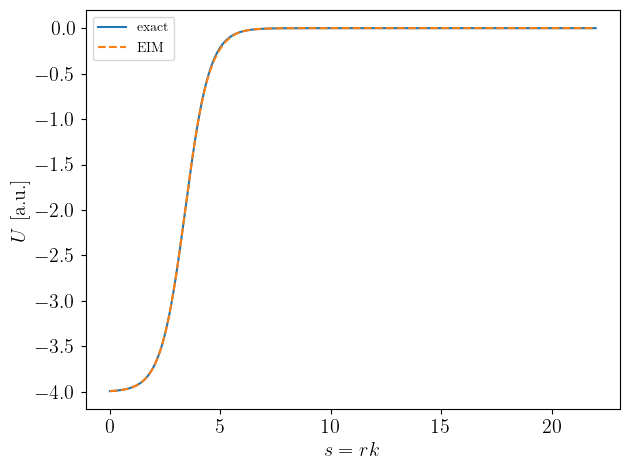

In [100]:
R_test = 3.1
plt.plot(s, woods_saxon_tilde(s, (V0, R_test, a)),  label="exact")
plt.plot(s, ws_affine_decomp(s, (V0, R_test, a), T), '--', label="EIM")

plt.xlabel(r"$s = r k$")
plt.ylabel(r"$U$ [a.u.]")
plt.legend()
handle_plot("result_eim")
plt.close()


Nice! By messing with the choice of sample points, we can see this method is very sensitive to the choice. This motivates the need for a greedy algorithm that can optimally choose the next sample point to maximize the variance, conditional on the initial set. We will explore this choice in the next section.

Another thing to notice is that the method fails to extrapolate; if $R_{test} \notin [R_{min}, R_{max}]$ we visually see poor agreement. This is (in a simplified way) because linear dimensionality reduction techniques, such as the Reduced Basis Method (and by extension the Empirical Interpolation Method), do not do well with problems where the function to be approximated gets displaced in the "x" direction (s in this case). For an extreme example see the infinite well example in Figure 1 of [this paper](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.106.054322).

# Building the RBM for the affinely-decomposed problem

Now that we have our affine decomposition for the Woods-Saxon potential, we can use it in a scattering RBM. First, we will select a new, smaller, set of training points, and calculate solutions for each one. We will borrow most of the RBM machinery from the previous section, with a few key differences that we will highlight.

In [101]:
initial_conditions = np.array([0.0, 1.0]) # initial phi(0) and phi'(0) conditions

def solve_se(theta, l):
    result = solve_ivp(
        lambda s, phi: np.array([phi[1],
            (woods_saxon_tilde(s, theta) + l*(l+1)/s**2 - 1.0) * phi[0]]),
        s_endpts, initial_conditions, rtol=1e-12, atol=1e-12, dense_output=True
    )
    phi = result.sol(s)[0, :]
    return s, phi

Now we construct our training basis:

In [102]:
n_train_pts = 25

# Only consider the s-waves
l = 0

# construct RB training set
training_set = np.linspace(R_min, R_max, n_train_pts)

training_points = np.array([
    (V0, R_train, a) for R_train in  training_set
])

# construct RB
training_solutions = np.array(
    [solve_se(theta, l)[1] for theta in training_points]
).T

# add free wave soln to RB, subtract from other basis elements. The potential is evaluated at (V_0=0, R=1, a=1) to avoid
#dividing by zero in the exponential. Since V_0=0, it is indeed a free solution.
phi_0 = solve_se( (0, 1, 1), l)[1]

training_solutions_sub = np.zeros_like(training_solutions.T)

for i in range(training_solutions.shape[1]):
    training_solutions_sub[i,:] = training_solutions.T[i,:].copy() - phi_0
    

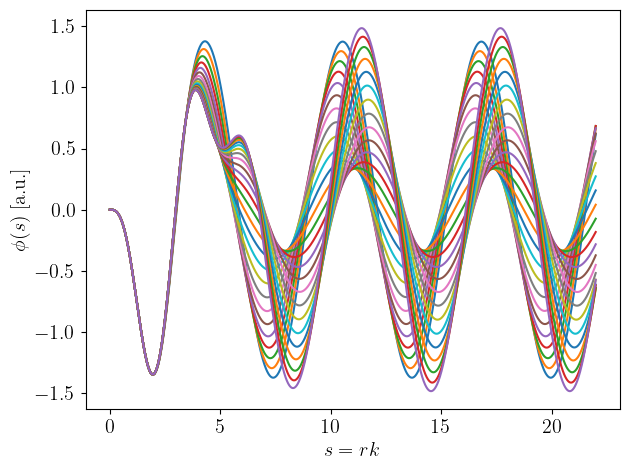

In [103]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

for u in training_solutions_sub:
    ax.plot(s, u)

ax.set_ylabel(r'$\phi(s)$ [a.u.]')
ax.set_xlabel(r'$s  = rk$')
handle_plot("training_rbm")
plt.close()

Now, let's construct our RBM, selecting only the important information from our preliminary basis with PCA.

In [104]:
U_rb, S_rb, _ = np.linalg.svd(training_solutions_sub.T, full_matrices=False)

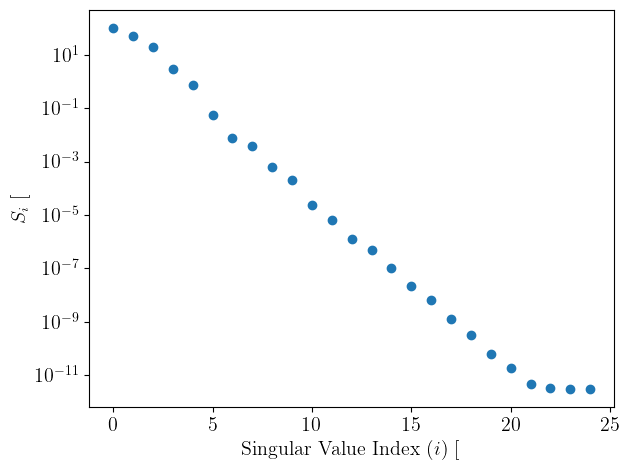

In [105]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

ax.scatter(np.arange(S_rb.size), S_rb/S_rb[0]*100)

ax.set_yscale('log')
ax.set_xlabel(r'Singular Value Index ($i$) [%]')
ax.set_ylabel(r'$S_i $ [%]')
handle_plot("training_svd")
plt.close()

In [106]:
sv_colors = plt.cm.plasma( S_rb/np.sum(S_rb) ) 

In [107]:
nbasis = 5

# we finally have our reduced basis
rb = U_rb[:,:nbasis]

# as before, we choose this basis to be our Galerkin projectors
psi = rb
k * R_max
k * R_min

3.2996876162467688

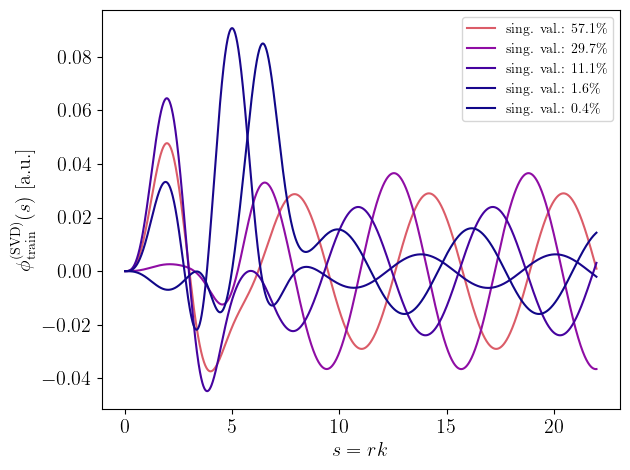

In [108]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

for i in range(nbasis):
    ax.plot(s, rb[:,i], label="sing. val.: {:1.1f}\%".format(100*S_rb[i]/np.sum(S_rb)), color=sv_colors[i])

ax.set_xlabel(r'$s = rk$')
ax.set_ylabel(r'$\phi_{\rm train}^{({\rm SVD})} (s)$ [a.u.]');
plt.legend()
handle_plot("rb")
plt.close()

Excellent! We have our reduced basis $\{ \phi_i \}$. We will use the reduced basis itself as our Galerkin projectors $\psi_i=\phi_i$, so we would like to simply project our operator into the reduced basis:

\begin{equation}
    \langle \psi_j | F(\hat\phi) \rangle = \langle \psi_j | F(\phi_0) \rangle + \sum_k ^n a_k\langle \psi_j | F(\phi_k) \rangle =0,\ \text{for } j, ... n 
\end{equation}




We can calculate  the low-dimensional matrix $\mathbf{F}(S)$: 

\begin{equation}
\mathbf{F}(S)_{jk} =  \langle \phi_j | \left[ -\frac{d^2}{ds^2}+\frac{\ell(\ell+1)}{s^2}+\tilde U(s; S)-1 \right] | \phi_k \rangle,
\end{equation}

and solve the inhomogenous matrix equation:
\begin{equation}
\mathbf{F}(S) \vec{a} = \Phi_0,
\end{equation}

where $\Phi_0$ is a short-hand notation for the list of projections of opperator acting on the free solution $\Phi_0=\{ \langle \psi_1 | F(S)|\phi_0 \rangle, \langle \psi_2 | F(S)|\phi_0 \rangle , ... \langle \psi_n | F(S)|\phi_0 \rangle\} $, an $\vec{a}=\{a_1,a_2,...a_n\}$ holds the coefficients for expanding our solution in the reduced basis.


Now, however, instead of using Woods-Saxon $ \tilde  U(s;S) $ defined above, we use our affine decomposition $\tilde{U}_\text{EIM}(s; S)  = \sum_\kappa^M \beta_\kappa(S) U_\kappa(s) $. We define $\tilde{\mathbf{F}}(S) \approx \mathbf{F}(S)$ as follows:

\begin{equation}
\tilde{F}(S)_{jk} =  \langle \phi_j | \left[ -\frac{d^2}{ds^2}+\frac{\ell(\ell+1)}{s^2} + \sum_\kappa^M \beta_\kappa (S) U_\kappa(s)-1 \right] | \phi_k \rangle.
\end{equation}

We just need then to calculate the matrix elements $\langle \phi_j | U_\kappa(s) | \phi_k \rangle$ . Then, for any value of $S$, we can simply grab our coefficients from the functions $\beta_\kappa(S)$ that we calculated, do the weighted sum, and we have our projected potential! 

<!-- Note: because we added $\phi_0$, the free solution, to our basis set, our projected equation approximating $\mathbf{F}(S) \vec{\phi} = 0$ gets an inhomogenous term. We now have: -->


<!-- \begin{equation}
\tilde{F}(S)_{ij} \psi_i = \langle \psi_j | F(S) | \phi_0 \rangle.
\end{equation} -->

In the code below, we make the definitions $A_{ij} = \tilde{F}(S)_{ij}$ and $b_j = \langle \psi_j | F(S) | \phi_0 \rangle$, resulting in the matrix equation $\mathbf{A} \vec{a} = \vec{b}$, where the elements of $\vec{a}$ are the coefficients of the emulated solution in the reduced basis.

We will use the same affine decomposition on the RHS as we did on the LHS. Let's see how that looks below:

In [109]:
# pre-compute matrix elements of affinely-decomposed Woods-Saxon
# NOTE: real application should use something like np.trapz to integrate over s -
# not sure how to do that 'pythonically'

# U_proj[k,i,j]  == <psi_i(s) | U_k(s) | psi_j(s) > 
U_proj = np.einsum('si,sj,sk', U, np.conj(rb) , rb)


# matrix element for inhomogenous term
# U_0[k,i]  == <psi_i(s) | U_k(s) | phi_0(s) >
U_0 = np.einsum('si,sj,s', U, np.conj(rb) , phi_0)


We can also precompute the other terms in $\mathbf{A}$ and $\vec{b}$ in the exact same way as the previous section:

In [110]:
# pre-compute matrix elements of the rest of F, as in the previous section (leave out potential contribution for now)
# matrix element of derivative, angular momentum, and norm/identity (e.g. <psi_j | psi_i> ) components
A = psi.T @ (
             - np.gradient(np.gradient(rb, s, axis=0), s, axis=0)  
             + np.einsum('s,s...', l*(l+1)/(s*s) , rb) 
             - rb
            )

# matrix element of inhomogenous term, minus the potential contribution
b = -psi.T @ (
                - np.gradient(np.gradient(phi_0, s), s) 
                + l*(l+1)/(s*s) * phi_0 
                - phi_0
             )

Now that all of our matrix elements are precomputed, given a value for $S$ we care to find a solution for, we construct a matrix problem $\mathbf{A} \vec{x} = \vec{b}$ in the reduced basis, and solve it!

In [111]:
def rbm_emulator(S):
    '''
    Given an S value, appropriately constructs the reduced basis operator from a weighted (by beta_k(S))
    sum of the pre-computed matrix elements, and solved the A psi = b system. 
    Returns the coefficients of the emulated solution projected onto the reduced basis
    '''
    betas = beta(S)
    
    # potential contributions to A and b
    A_pot = np.einsum('k,k...', betas , U_proj)
    b_pot = np.einsum('k,k...', betas , U_0)

    return np.linalg.solve(A + A_pot, b - b_pot)

In [112]:
# now let's test it out
R_test = 4.2
emu_proj = rbm_emulator(R_test*k)
emu_proj

array([-18.90009614,  -6.77654918,  -6.38071529,  -0.3728465 ,
         0.10002872])

In [113]:
# change of coordinates from the space of the reduced basis back into the coordinate space
emu = np.sum(emu_proj * rb, axis=1) + phi_0

# exact solution of the exact Woods-Saxon potential
exact = solve_se((V0, R_test, a), l)[1]

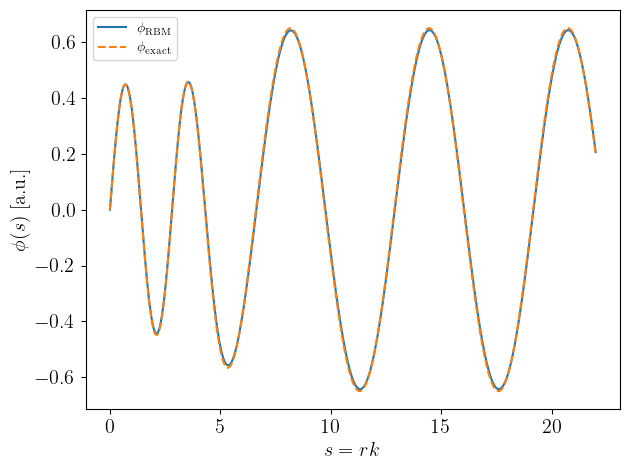

In [114]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

ax.plot(s, emu, linestyle='-', label=r'$\phi_{\rm RBM}$')
ax.plot(s, exact, linestyle='--', label=r'$\phi_{\rm exact}$')

ax.set_xlabel(r'$s = rk$')
ax.set_ylabel(r'$\phi(s)$ [a.u.]')
ax.legend()
handle_plot("rb_result")
plt.close()

Not bad!

Let's test the accuracy of the RBM at constructing and important quantity, the R-Matrix, over a range of test $R$ values:

In [115]:
from scipy import special as sc

def phase_shift(s,phi):
    smax = s[-1]
    ds   = smax - s[-1] 
    A1 = (smax - ds) * sc.spherical_jn(l, k * (smax - ds)) * phi[-1] \
       - smax * sc.spherical_jn(l, k * smax) * phi[-2]
    A2 = (smax - ds) * sc.spherical_yn(l, k * (smax - ds)) * phi[-1] \
       - smax * sc.spherical_yn(l, k * smax) * phi[-2]

    # calculate phase shift
    return np.arctan2(A1,A2) * 180/(2*np.pi)


Let's test the speedup and accuracy of our new RBM!

In [116]:
# construct test space, with a little bit of extrapolation outside the training region
test_widths = np.linspace(R_min -0.7, R_max+0.7 , 200)

import time

def exact_solution(R):
    return solve_se((V0, R, a), l)[1]

def emulator(R):
    return np.sum(rbm_emulator(R*k) * rb, axis=1) + phi_0

In [117]:

# calculate exact solutions 
tic = time.perf_counter()
delta_exact = np.array(
    [ phase_shift(exact_solution(width),s) for width in test_widths]
)
toc = time.perf_counter()
print(f"High-fidelity solver ran in {toc - tic:0.4f} seconds")
hf_time = float(toc - tic)

High-fidelity solver ran in 25.8502 seconds


In [118]:
# solve RB-projected problem 
tic = time.perf_counter()
delta_rbm = np.array(
    [ phase_shift(emulator(width), s) for width in test_widths]
)
toc = time.perf_counter()
rbm_time = float(toc - tic)
print(f"RBM emulator ran in {toc - tic:0.4f} seconds")
print("That's a {}x speedup!".format(hf_time/rbm_time))

RBM emulator ran in 0.0252 seconds
That's a 1026.4761535215414x speedup!


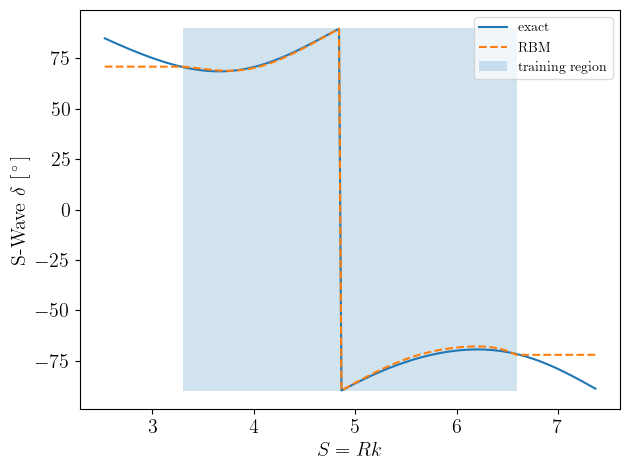

In [119]:
mx = 90
plt.plot(test_widths*k,  delta_exact, label="exact" )
plt.plot(test_widths*k,  delta_rbm, label="RBM", linestyle="--" )
plt.fill_between( [k*R_min, k*R_max], y1=[mx,mx], y2=[-mx,-mx] , alpha=0.2, label="training region")

plt.xlabel(r"$S = R k$")
plt.ylabel(r"S-Wave $\delta$ [$\,^\circ \,$]")
plt.legend(loc='upper right',  fancybox=True, framealpha=0.7)
handle_plot("rb_delta")
plt.close()